# Q7 - Sobel Filtering

In [42]:
import numpy as np, cv2 as cv, matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../data/a1images")
RESULTS = Path("../results/q7")
RESULTS.mkdir(parents=True, exist_ok=True)

img_path = DATA / "einstein.png"
img = cv.imread(str(img_path), cv.IMREAD_GRAYSCALE)
assert img is not None, f"Image not found at {img_path}"
print("Loaded:", img_path, "shape:", img.shape, "dtype:", img.dtype)

Loaded: ../data/a1images/einstein.png shape: (380, 364) dtype: uint8


In [43]:
# Sobel kernels
Kx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]], dtype=np.float32)
Ky = Kx.T

# separable factors
smooth = np.array([1, 2, 1], dtype=np.float32)      # column/row smoothing
deriv = np.array([1, 0, -1], dtype=np.float32)     # column/row derivative

In [44]:
# helpers
def mag(gx, gy):
    m = np.sqrt(gx*gx + gy*gy)
    return m


def save_panel(images, titles, fname):
    cols = len(images)
    plt.figure(figsize=(4*cols, 4))
    for i, (im, t) in enumerate(zip(images, titles), 1):
        plt.subplot(1, cols, i)
        plt.imshow(im, cmap='gray')
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(RESULTS/fname, dpi=150)
    plt.show()


def normalize_u8(im):
    im = np.abs(im)
    mx = im.max() if im.max() > 0 else 1.0
    return np.clip(im / mx * 255.0, 0, 255).astype(np.uint8)

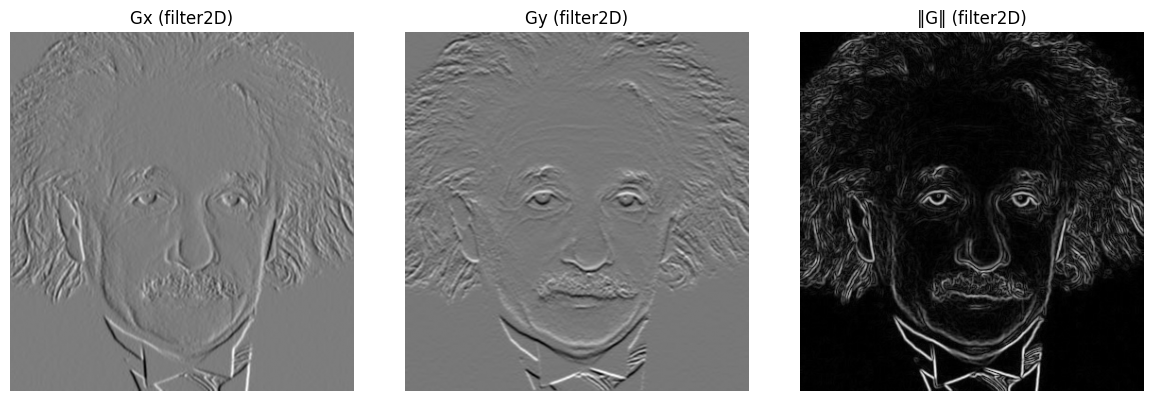

In [45]:
# (a) Sobel with cv.filter2D
Gx_a = cv.filter2D(img, ddepth=cv.CV_32F, kernel=Kx,
                   borderType=cv.BORDER_REPLICATE)
Gy_a = cv.filter2D(img, ddepth=cv.CV_32F, kernel=Ky,
                   borderType=cv.BORDER_REPLICATE)

# Compute magnitude
M_a = mag(Gx_a, Gy_a)

# Normalize to signed gradients for embossed effect
def normalize_u8_signed(im):
    """Normalize the signed gradient to [0, 255] with 128 as mid-gray."""
    im = im.astype(np.float32)
    min_val = np.min(im)
    max_val = np.max(im)
    # Shift negative values to mid-gray (128) and stretch to [0,255]
    im = (im - min_val) / (max_val - min_val) * 255
    im = im - 128  # Make 0 gradient at 128, positive at >128, negative at <128
    return np.clip(im + 128, 0, 255).astype(np.uint8)  # Ensure 0-255 range

# Apply normalization to gradients and magnitude
Gx_a_u8 = normalize_u8_signed(Gx_a)
Gy_a_u8 = normalize_u8_signed(Gy_a)
M_a_u8 = normalize_u8_signed(M_a)

# Save signed gradients and magnitude (embossed)
cv.imwrite(str(RESULTS/"q7a_gx.png"), Gx_a_u8)
cv.imwrite(str(RESULTS/"q7a_gy.png"), Gy_a_u8)
cv.imwrite(str(RESULTS/"q7a_mag.png"), M_a_u8)

# Panel (embossed Sobel results)
save_panel([Gx_a_u8, Gy_a_u8, M_a_u8],
           ["Gx (filter2D)", "Gy (filter2D)", "‖G‖ (filter2D)"], "q7a_panels.png")

In [46]:
# (b) Your own convolution (replicate borders)
def conv2_replicate(src: np.ndarray, k: np.ndarray) -> np.ndarray:
    kh, kw = k.shape
    ph, pw = kh//2, kw//2
    pad = cv.copyMakeBorder(src, ph, ph, pw, pw, cv.BORDER_REPLICATE)
    # convolution = correlation with flipped kernel
    kf = np.flipud(np.fliplr(k))
    out = np.zeros_like(src, dtype=np.float32)
    # simple, clear loops (fine for 3x3 Sobel)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            patch = pad[i:i+kh, j:j+kw]
            out[i, j] = np.sum(patch * kf)
    return out

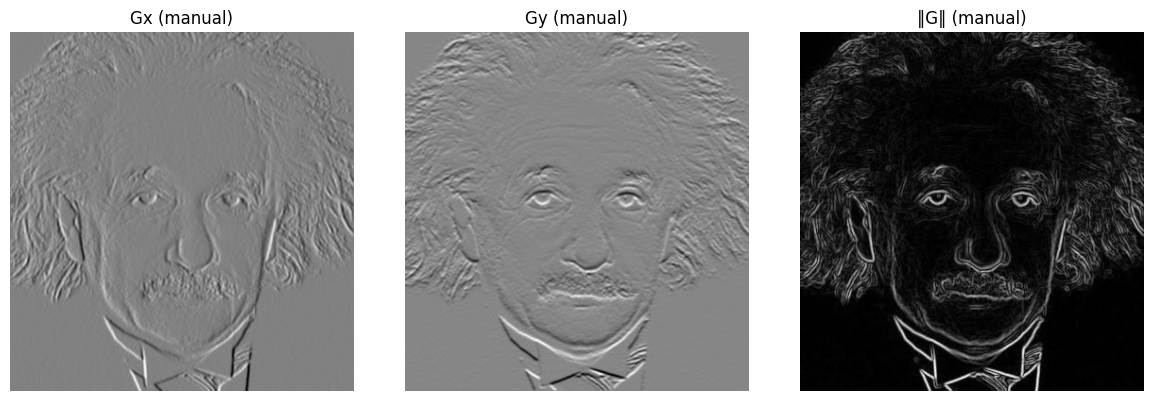

In [47]:
Gx_b = conv2_replicate(img, Kx)
Gy_b = conv2_replicate(img, Ky)
M_b = mag(Gx_b, Gy_b)

# Normalize to signed gradients for embossed effect
Gx_b_u8 = normalize_u8_signed(Gx_b)
Gy_b_u8 = normalize_u8_signed(Gy_b)
M_b_u8 = normalize_u8_signed(M_b)

cv.imwrite(str(RESULTS/"q7b_gx.png"), Gx_b_u8)
cv.imwrite(str(RESULTS/"q7b_gy.png"), Gy_b_u8)
cv.imwrite(str(RESULTS/"q7b_mag.png"), M_b_u8)
save_panel([Gx_b_u8, Gy_b_u8, M_b_u8],
           ["Gx (manual)", "Gy (manual)", "‖G‖ (manual)"], "q7b_panels.png")

/var/folders/l6/b2n5bsdj5svby5kp8r523_zr0000gn/T/ipykernel_62710/3377450609.py:17: RuntimeWarning: invalid value encountered in divide
  im = (im - min_val) / (max_val - min_val) * 255
/var/folders/l6/b2n5bsdj5svby5kp8r523_zr0000gn/T/ipykernel_62710/3377450609.py:19: RuntimeWarning: invalid value encountered in cast
  return np.clip(im + 128, 0, 255).astype(np.uint8)  # Ensure 0-255 range


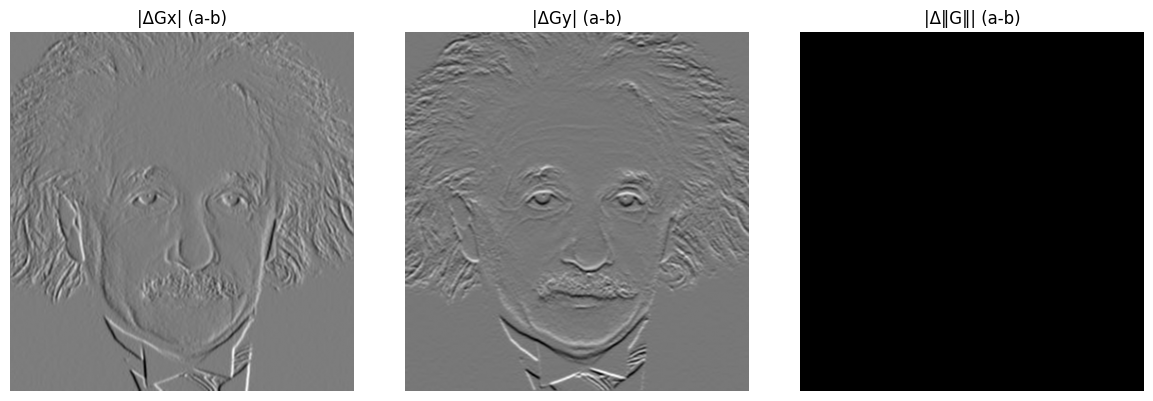

In [48]:
# difference check (a vs b)
save_panel([normalize_u8_signed(Gx_a - Gx_b),
            normalize_u8_signed(Gy_a - Gy_b),
            normalize_u8_signed(M_a - M_b)],
           ["|ΔGx| (a-b)", "|ΔGy| (a-b)", "|Δ‖G‖| (a-b)"], "q7_diff_ab.png")